In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget -P /content/drive/MyDrive/ https://seafile.projekt.uni-hannover.de/seafhttp/files/5454274d-aeb7-47c7-ba7c-db9c20b07801/Potsdam.zip

In [ ]:
# !unzip /content/drive/MyDrive/J/Potsdam/2_Ortho_RGB.zip -d /content/drive/MyDrive/J/Potsdam/


In [ ]:
# !unzip /content/drive/MyDrive/J/Potsdam/5_Labels_for_participants.zip -d /content/drive/MyDrive/J/Potsdam/5_Labels_for_participants/

In [ ]:
# !unzip /content/drive/MyDrive/J/Potsdam/5_Labels_for_participants_no_Boundary.zip -d /content/drive/MyDrive/J/Potsdam/5_Labels_for_participants_no_Boundary/

In [3]:
# !ls /content/drive/MyDrive/J/Potsdam/5_Labels_for_participants.zip

/content/drive/MyDrive/J/Potsdam/5_Labels_for_participants.zip


# New Section

In [4]:
# imports and stuff
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable

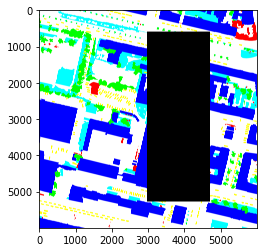

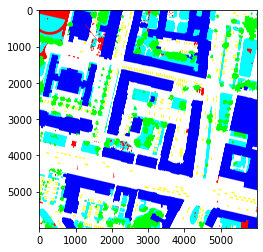

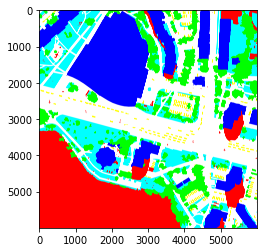

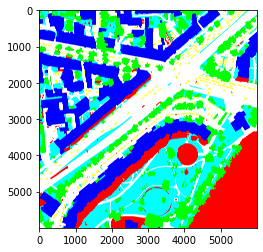

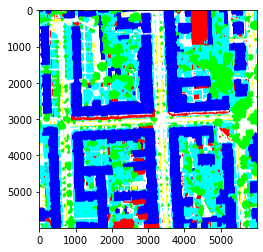

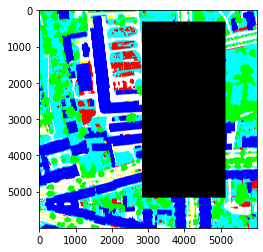

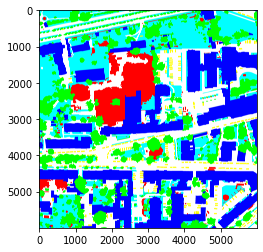

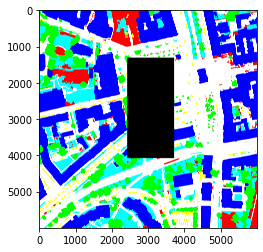

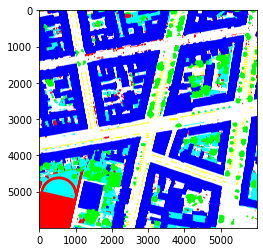

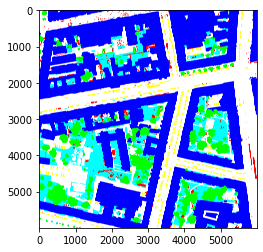

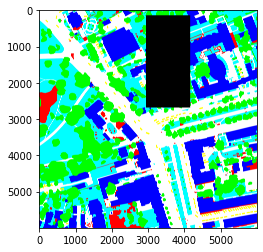

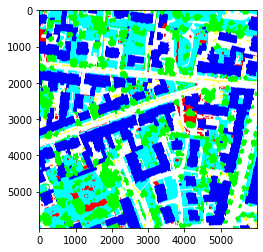

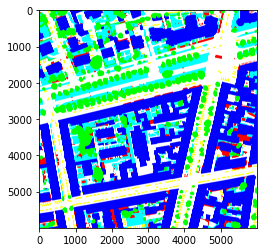

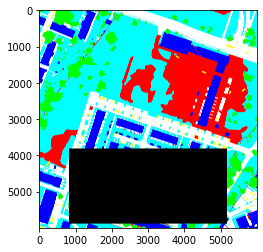

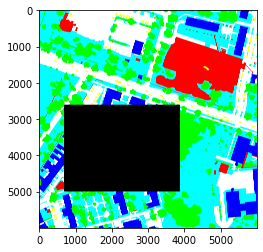

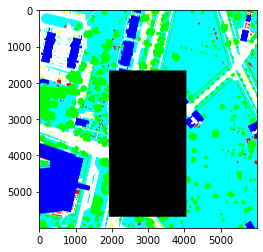

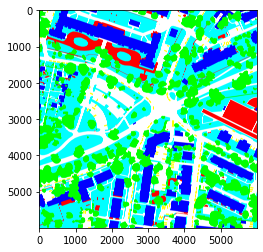

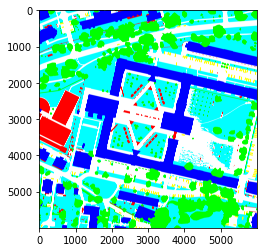

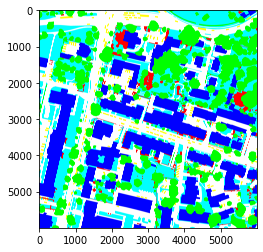

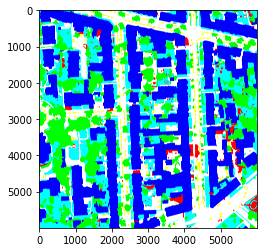

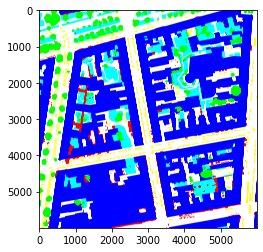

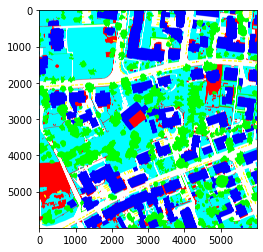

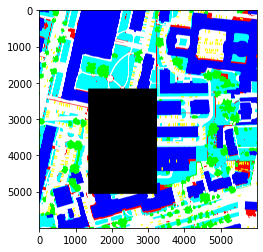

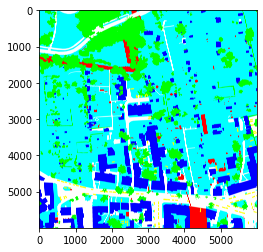

In [5]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import os

NEW_FOLDER = '../content/drive/MyDrive/J/Potsdam/5_Labels_for_participants/5_Labels_for_participants/'

# all_files = sorted(glob(NEW_FOLDER.replace('{}', '*')))
for im in os.listdir(NEW_FOLDER):
  if (im.endswith(".tif")):
    img = io.imread('../content/drive/MyDrive/J/Potsdam/5_Labels_for_participants/5_Labels_for_participants/'+ im)
    # plt.imshow(img)
    # plt.show()
    # print(img)
    # read input image
    # img = Image.open(im)
    # print(img)
    # print('hello') 

    # define a transform to perform transformations
    transform = T.Compose([T.ToTensor(), T.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False), T.ToPILImage()])
    imgs = transform(img)
    # plt.imshow(imgs)
    # plt.show()
    # # use dictionary comprehension to take four output images
    # imgs = [transform(img) for _ in range(1)]
    plt.imshow(imgs)
    plt.show()
    Image=imgs
    # print(imgs)
    Image.save('../content/drive/MyDrive/J/Potsdam/5_Labels_for_participants/REdata/'+ im)
    # # display four output images
    # fig = plt.figure(figsize=(7,4))
    # rows, cols = 1,1
    # for j in range(0, len(imgs)):
    #   fig.add_subplot(rows, cols, j+1)
    #   plt.imshow(imgs[j])
    #   plt.xticks([])
    #   plt.yticks([])
    # plt.show()

In [6]:
WINDOW_SIZE = (256, 256) # Patch size
STRIDE = 32 # Stride for testing
IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
# FOLDER = "../content/drive/MyDrive/Potsdam/PotsdamData/" 
BATCH_SIZE = 10 # Number of samples in a mini-batch

LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

DATASET = 'Potsdam'
# MAIN_FOLDER = FOLDER + 'Potsdam/'

DATA_FOLDER = '../content/drive/MyDrive/J/Potsdam/2_Ortho_RGB/top_potsdam_{}_RGB.tif'
LABEL_FOLDER = '../content/drive/MyDrive/J/Potsdam/5_Labels_for_participants/REdata/top_potsdam_{}_label.tif'
ERODED_FOLDER = '../content/drive/MyDrive/J/Potsdam/5_Labels_for_participants_no_Boundary/5_Labels_for_participants_no_Boundary/top_potsdam_{}_label_noBoundary.tif'

**Visualizing the dataset**

First, let's check that we are able to access the dataset and see what's going on. We use scikit-image for image manipulation.

As the ISPRS dataset is stored with a ground truth in the RGB format, we need to define the color palette that can map the label id to its RGB color. We define two helper functions to convert from numeric to colors and vice-versa.

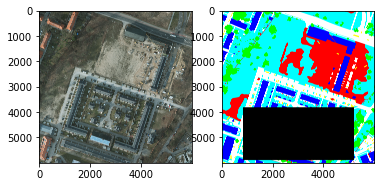

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


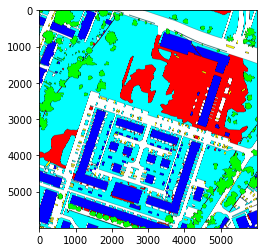

Ground truth in numerical format has shape (6000,6000) : 
 [[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


In [8]:
# ISPRS color palette
# Let's define the standard ISPRS color palette
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0)}     # Clutter (red)
           #6 : (0, 0, 0)}       # Undefined (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# We load one tile from the dataset and we display it
img = io.imread('../content/drive/MyDrive/J/Potsdam/2_Ortho_RGB/top_potsdam_2_10_RGB.tif')
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img)

# We load the ground truth
gt = io.imread('../content/drive/MyDrive/J/Potsdam/5_Labels_for_participants/REdata/top_potsdam_2_10_label.tif')
fig.add_subplot(122)
plt.imshow(gt)
plt.show()

gte = io.imread('../content/drive/MyDrive/J/Potsdam/5_Labels_for_participants_no_Boundary/5_Labels_for_participants_no_Boundary/top_potsdam_2_10_label_noBoundary.tif')
fig.add_subplot(122)
plt.imshow(gte)
plt.show()

# We also check that we can convert the ground truth into an array format
array_gt = convert_from_color(gt)
print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)

Here, at this point we need to define a bunch of utils functions.

In [25]:
# Utils

def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]

def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=LABELS):
  cm = confusion_matrix(
          gts,
          predictions
          # range(len(label_values)))
  )
  print("Confusion matrix :")
  print(cm)    

  print("---")

  # Compute global accuracy
  total = sum(sum(cm))
  accuracy = sum([cm[x][x] for x in range(len(cm))])
  accuracy *= 100 / float(total)
  print("{} pixels processed".format(total))
  print("Total accuracy : {}%".format(accuracy))

  print("---")
      
  # Compute F1 score
  F1Score = np.zeros(len(label_values))
  for i in range(len(label_values)):
      try:
          F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
      except:
          # Ignore exception if there is no element in class i for test set
          pass
  print("F1Score :")
  for l_id, score in enumerate(F1Score):
      print("{}: {}".format(label_values[l_id], score))


  print("---")
          
  # Compute kappa coefficient
  total = np.sum(cm)
  pa = np.trace(cm) / float(total)
  pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
  kappa = (pa - pe) / (1 - pe);
  print("Kappa: " + str(kappa))
  return accuracy
    
        


**Loading the dataset**

We define a PyTorch dataset (torch.utils.data.Dataset) that loads all the tiles in memory and performs random sampling. Tiles are stored in memory on the fly.

The dataset also performs random data augmentation (horizontal and vertical flips) and normalizes the data in [0, 1].

In [10]:
# Dataset class

class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()
        
        self.augmentation = augmentation
        self.cache = cache
        
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))

        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}
            
    
    def __len__(self):
        # Default epoch size is 10 000 samples
        return 10000


    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)

    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/255 * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data
            
        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else: 
            # Labels are converted from RGB to their numeric values
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),

                torch.from_numpy(label_p))
        
        
        



**Network definition**

We can now define the Fully Convolutional network based on the SegNet architecture. We could use any other network as drop-in replacement, provided that the output has dimensions (N_CLASSES, W, H) where W and H are the sliding window dimensions (i.e. the network should preserve the spatial dimensions).

In [11]:
class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)
    
    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)
        
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)
        
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)
        
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)
        
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)
        
        self.apply(self.weight_init)
        
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)
        
        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)
        
        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)
        
        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)
        
        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)
        
        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))
        
        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))
        
        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))
        
        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))
        
        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x))
        return x











 
import torch

import torchvision.transforms as T

from PIL import Image

import matplotlib.pyplot as pltimport torch

import torchvision.transforms as T

from PIL import Image

import matplotlib.pyplot as pltimport torch

import torchvision.transforms as T

from PIL import Image

import matplotlib.pyplot as pltimport torch

import torchvision.transforms as T

from PIL import Image

import matplotlib.pyplot as pltimport torch

import torchvision.transforms as T

from PIL import Image

import matplotlib.pyplot as pltimport torch

import torchvision.transforms as T

from PIL import Image

import matplotlib.pyplot as pltimport torch

import torchvision.transforms as T

from PIL import Image

import matplotlib.pyplot as pltimport torch

import torchvision.transforms as T

from PIL import Image

import matplotlib.pyplot as pltimport torch

import torchvision.transforms as T

from PIL import Image

import matplotlib.pyplot as pltimport torch

import torchvision.transforms as T

from PIL import Image

import matplotlib.pyplot as plt

We can now instantiate the network using the specified parameters. By default, the weights will be initialized using the policy.

In [12]:
# instantiate the network
net = SegNet()


We download and load the pre-trained weights from VGG-16 on ImageNet. This step is optional but it makes the network converge faster. We skip the weights from VGG-16 that have no counterpart in SegNet.

In [13]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))
        
try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignore missing keys
    pass

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_1_bn.num_batches_tracked
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.7.bias to conv1_2_bn.num_batches_tracked
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping fe

Then, we load the network on GPU.

In [14]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [15]:
net.cuda()

SegNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1_bn): BatchNorm2d(256, eps=1e-05, mom

**cuda** **debugging**

In [ ]:
#!CUDA_LAUNCH_BLOCKING=1

In [ ]:
#os.system('CUDA_LAUNCH_BLOCKING=1')

0

In [ ]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [16]:
torch.cuda.is_available()


True

In [ ]:
#!nvcc --version 


/bin/bash: nvcc: command not found


**Loading the data**

We now create a train/test split. If you want to use another dataset, you have to adjust the method to collect all filenames. In our case, we specify a fixed train/test split for the demo.

In [17]:
# Load the datasets
all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
all_ids = [f.split('potsdam_')[-1].split('_label')[0] for f in all_files]
# Random tile numbers for train/test split
train_ids = random.sample(all_ids,  len(all_ids) )
test_ids = list(set(all_ids) - set(train_ids))

# Example of a train/test split on Potsdam :
train_ids = ['2_10', '2_12', '3_10', '3_12', '4_10', '4_12', '5_10', '5_12', '6_10', '6_12', '7_10', '7_12']
test_ids = ['2_11', '3_11', '4_11', '5_11'] 

print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)

train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)

Tiles for training :  ['2_10', '2_12', '3_10', '3_12', '4_10', '4_12', '5_10', '5_12', '6_10', '6_12', '7_10', '7_12']
Tiles for testing :  ['2_11', '3_11', '4_11', '5_11']


**Designing the optimizer**

We use the standard Stochastic Gradient Descent algorithm to optimize the network's weights.

The encoder is trained at half the learning rate of the decoder, as we rely on the pre-trained VGG-16 weights. We use the torch.optim.lr_scheduler to reduce the learning rate by 10 after 25, 35 and 45 epochs.

In [18]:
base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

In [19]:
from IPython.display import clear_output
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Use the network on the test set
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    net.eval()

    for img, gt, gt_e in tqdm(zip(test_images, test_labels,eroded_labels), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,3,1)
                    plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    fig.add_subplot(1,3,2)
                    plt.imshow(convert_to_color(_pred))
                    fig.add_subplot(1,3,3)
                    plt.imshow(gt)
                    clear_output()
                    plt.show()
                    
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure()
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,3)
        plt.imshow(gt)
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt_e)

        clear_output()
        # Compute some metrics
        metrics(pred.ravel(), gt_e.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

In [20]:
from IPython.display import clear_output

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 5):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    weights = weights.cuda()

    # criterion = nn.NLLLoss2d(weight=weights)
    criterion=nn.BCEWithLogitsLoss(weight=weights)
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            output = net(data)
            loss = CrossEntropy2d(output, target, weight=weights)
            loss.backward()
            optimizer.step()
            
            losses[iter_] = loss.item()
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            if iter_ % 100 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(e, epochs, batch_idx, len(train_loader),100. * batch_idx / len(train_loader), loss.item(), accuracy(pred, gt)))
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.show()
            iter_ += 1
            
            del(data, target, loss)
            
        if e % save_epoch == 0:
            # We validate with the largest possible stride for faster computing
            acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
            torch.save(net.state_dict(), './segnet256_epoch{}_{}'.format(e, acc))
    torch.save(net.state_dict(), './segnet_final')

**Training the network**

Let's train the network for 3 epochs and increase gradually. The matplotlib graph is periodically updated with the loss plot and a sample inference.

In [ ]:
# !apt-get --purge remove cuda nvidia* libnvidia-*
# !dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
# !apt-get remove cuda-*
# !apt autoremove
# !apt-get update

In [ ]:
# !wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
# !apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
# !apt-get update
# !apt-get install cuda-9.2

In [ ]:
# ! /usr/local/cuda/bin/nvcc --version

/bin/bash: /usr/local/cuda/bin/nvcc: No such file or directory


In [ ]:
!ls /usr/local/cuda-9.2/bin/nvcc --version

ls (GNU coreutils) 8.28
Copyright (C) 2017 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>.
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.

Written by Richard M. Stallman and David MacKenzie.


In [ ]:
# !source .bashrc

/bin/bash: .bashrc: No such file or directory


In [ ]:
# !cd /usr/local/

In [ ]:
# !pwd

/content


In [ ]:
!ls

cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb  sample_data
drive						   vgg16_bn-6c64b313.pth


In [ ]:
!nvidia-smi

Mon Sep 19 04:29:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    35W / 250W |    757MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Train (epoch 2/2) [900/1000 (90%)]	Loss: 1.124906	Accuracy: 29.9407958984375


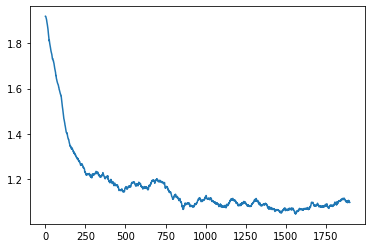

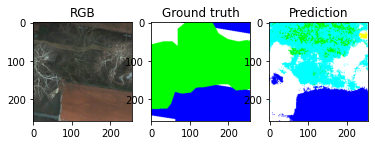

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:131: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [21]:
# train(net, optimizer, 2, scheduler)
# !CUDA_LAUNCH_BLOCKING="1"

#!pip install git+https://github.com/deepset-ai/haystack.git
# !echo "output is " $(CUDA_LAUNCH_BLOCKING)
#print("weights is ", vgg16_weights)
train(net, optimizer, 2, scheduler)

**Testing the network**

Now that the training has ended, we can load the final weights and test the network using a reasonable stride, e.g. half or a quarter of the window size. Inference time depends on the chosen stride, e.g. a step size of 32 (75% overlap) will take ~15 minutes, but no overlap will take only one minute or two.

In [ ]:
!pip install farm-haystack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
net.load_state_dict(torch.load('./segnet_final'))


<All keys matched successfully>

In [26]:
all_preds, all_gts = test(net, test_ids, all=True, stride=32)

Confusion matrix :
[[ 9409441  1113414  2576588     1665   189696        0]
 [ 1636852 10554791   843669      156     4419        1]
 [  154899   119483  3790154     2113      248        0]
 [  646626    89166  3335461     6971    32598        0]
 [   48626   129639     6192        3   485794        1]
 [  210770   296260   304327       46     9931        0]]
---
36000000 pixels processed
Total accuracy : 67.35319722222222%
---
F1Score :
roads: 0.7409586842563857
buildings: 0.8329669350562161
low veg.: 0.5079515988701686
trees: 0.0033825224854528726
cars: 0.6975083653937962
clutter: 0.0
---
Kappa: 0.5450400634654966
Confusion matrix :
[[31576161  3370243 10180132    12812   355984        2]
 [ 5496006 25568163  2066711     4991    10127        2]
 [ 1148263   446898 33198789    29336     3932        1]
 [ 1939044   199986 21280685    58358    46061        3]
 [  143204   386534    29893      108   984975        1]
 [ 1156328  1282372  2988002     2607    33286        0]]
---
144000000 

ValueError: ignored

In [30]:
print(test_ids)

['2_11', '3_11', '4_11', '5_11']


**Saving the results**

We can visualize and save the resulting tiles for qualitative assessment.

In [28]:
for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./inference_tile_{}.png'.format(id_), img)


NameError: ignored

In [ ]:
!pip install jovian

In [ ]:
import jovian

In [ ]:
jovian.commit(project='part1')

**CUDA INSTALL SECTION**





In [ ]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4 MB 13 kB/s 
     |████████████████████████████████| 12.8 MB 25.9 MB/s 
     |████████████████████████████████| 7.6 MB 4.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.12.1+cu113
    Uninstalling torchaudio-0.12.1+cu113:
      Successfully uninstalled torchaudio-0.12.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. 

In [ ]:
!pip install pytorch torchvision cudatoolkit==10.1 -c pytorch

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pytorch'


In [ ]:
!pip install --user scikit-image OpenEXR==1.3.2
!pip install --user torch==1.7.0+cu110 torchvision==0.8.1+cu110 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
torch.cuda.is_available()


In [ ]:
!sudo apt install -y nvidia-cuda-toolkit

Reading package lists... Done
Building dependency tree       
Reading state information... Done
nvidia-cuda-toolkit is already the newest version (9.1.85-3ubuntu1).
You might want to run 'apt --fix-broken install' to correct these.
The following packages have unmet dependencies:
 nvidia-cuda-toolkit : Depends: nvidia-cuda-dev (= 9.1.85-3ubuntu1) but it is not going to be installed
E: Unmet dependencies. Try 'apt --fix-broken install' with no packages (or specify a solution).


In [ ]:
!apt --fix-broken install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Correcting dependencies... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  nvidia-cuda-dev
Recommended packages:
  libnvcuvid1
The following NEW packages will be installed:
  nvidia-cuda-dev
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
53 not fully installed or removed.
Need to get 263 MB of archives.
After this operation, 734 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 nvidia-cuda-dev amd64 9.1.85-3ubuntu1 [263 MB]
Fetched 263 MB in 5s (57.5 MB/s)
(Reading database ... 161342 files and directories currently installed.)
Preparing to unpack .../nvidia-cuda-dev_9.1.85-3ubuntu1_amd64.deb ...
Unpacking nvidia-cuda-dev (9.1.85-3ubuntu1) ...
dpkg: error processing archive /v

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb

--2022-08-24 10:04:36--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.19.142
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 [following]
--2022-08-24 10:04:37--  https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?8OttnXARc_0YZLiGoOZAB6EiOLuou8SM_mJTp3LLssXy-6noBva2xZLD223DvU_EfqOCe0-ZSxTdZ3tETtXr5joPw-0UpA1vdgFN2gCwWWvOR

In [ ]:
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb

Selecting previously unselected package cuda-repo-ubuntu1604-9-2-local.
(Reading database ... 161342 files and directories currently installed.)
Preparing to unpack cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb ...
Unpacking cuda-repo-ubuntu1604-9-2-local (9.2.88-1) ...
Setting up cuda-repo-ubuntu1604-9-2-local (9.2.88-1) ...


In [ ]:
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub



OK


In [ ]:
!apt-get update


Get:1 file:/var/cuda-repo-9-2-local  InRelease
Ign:1 file:/var/cuda-repo-9-2-local  InRelease
Get:2 file:/var/cuda-repo-9-2-local  Release [574 B]
Get:2 file:/var/cuda-repo-9-2-local  Release [574 B]
Get:3 file:/var/cuda-repo-9-2-local  Release.gpg [819 B]
Get:3 file:/var/cuda-repo-9-2-local  Release.gpg [819 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB

In [ ]:
!apt-get install cuda


Reading package lists... Done
Building dependency tree       
Reading state information... Done
You might want to run 'apt --fix-broken install' to correct these.
The following packages have unmet dependencies:
 cuda : Depends: cuda-11-7 (>= 11.7.1) but it is not going to be installed
 nvidia-cuda-toolkit : Depends: nvidia-cuda-dev (= 9.1.85-3ubuntu1) but it is not going to be installed
E: Unmet dependencies. Try 'apt --fix-broken install' with no packages (or specify a solution).


In [ ]:
!sudo apt clean
!sudo apt update
!sudo apt purge nvidia-* 
!sudo apt autoremove
!sudo apt install -y cuda

Get:1 file:/var/cuda-repo-9-2-local  InRelease
Ign:1 file:/var/cuda-repo-9-2-local  InRelease
Get:2 file:/var/cuda-repo-9-2-local  Release [574 B]
Get:2 file:/var/cuda-repo-9-2-local  Release [574 B]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:15 http://ppa.launchpa

In [ ]:
!wget https://developer.download.nvidia.com/compute/cuda/11.1.0/local_installers/cuda_11.1.0_455.23.05_linux.run
!chmod +x cuda_11.1.0_455.23.05_linux.run 
!sudo ./cuda_11.1.0_455.23.05_linux.run 


--2022-08-24 10:29:51--  https://developer.download.nvidia.com/compute/cuda/11.1.0/local_installers/cuda_11.1.0_455.23.05_linux.run
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3498245611 (3.3G) [application/octet-stream]
Saving to: ‘cuda_11.1.0_455.23.05_linux.run.1’

cuda_11.1.0_455.23. 100%[===================>]   3.26G   188MB/s    in 20s     

2022-08-24 10:30:11 (165 MB/s) - ‘cuda_11.1.0_455.23.05_linux.run.1’ saved [3498245611/3498245611]

)07=
  Existing package manager installation of the driver found. It is strongly
  recommended that you remove this before continuing.
  Abort
>

In [ ]:
!sudo ./cuda_11.1.0_455.23.05_linux.run 






)07=
  Existing package manager installation of the driver found. It is strongly
  recommended that you remove this before continuing.
  Abort
>

In [ ]:
!sudo apt purge nvidia-*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia-*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia-*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia-*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia-*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia-*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia-*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia-*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia-*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia-*'
Note, selecting 'nvidia-fs-prebuilt' for glob 'nvidia-*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia-*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia-*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia-*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia-*'
Note, selecting 'nvidia-kernel-source-440-server' for g

In [ ]:
!sudo apt install -y cuda-11-7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
You might want to run 'apt --fix-broken install' to correct these.
The following packages have unmet dependencies:
 cuda-11-7 : Depends: cuda-runtime-11-7 (>= 11.7.1) but it is not going to be installed
             Depends: cuda-toolkit-11-7 (>= 11.7.1) but it is not going to be installed
             Depends: cuda-demo-suite-11-7 (>= 11.7.91) but it is not going to be installed
 nvidia-cuda-toolkit : Depends: nvidia-cuda-dev (= 9.1.85-3ubuntu1) but it is not going to be installed
E: Unmet dependencies. Try 'apt --fix-broken install' with no packages (or specify a solution).


In [ ]:
!sudo apt-get install cuda-10-0 cuda-toolkit-10-0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cuda-10-0 is already the newest version (10.0.130-1).
cuda-toolkit-10-0 is already the newest version (10.0.130-1).
cuda-toolkit-10-0 set to manually installed.
You might want to run 'apt --fix-broken install' to correct these.
The following packages have unmet dependencies:
 nvidia-cuda-toolkit : Depends: nvidia-cuda-dev (= 9.1.85-3ubuntu1) but it is not going to be installed
E: Unmet dependencies. Try 'apt --fix-broken install' with no packages (or specify a solution).


In [ ]:
!dpkg -l | grep -e cuda-.*9-1 | awk '{print $2}' | xargs -n1 sudo dpkg --purge --force-all

dpkg: error: --purge needs at least one package name argument

Type dpkg --help for help about installing and deinstalling packages [*];
Use 'apt' or 'aptitude' for user-friendly package management;
Type dpkg -Dhelp for a list of dpkg debug flag values;
Type dpkg --force-help for a list of forcing options;
Type dpkg-deb --help for help about manipulating *.deb files;

Options marked [*] produce a lot of output - pipe it through 'less' or 'more' !


In [ ]:
!sudo apt -f install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Correcting dependencies... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  nvidia-cuda-dev
Recommended packages:
  libnvcuvid1
The following NEW packages will be installed:
  nvidia-cuda-dev
0 upgraded, 1 newly installed, 0 to remove and 26 not upgraded.
53 not fully installed or removed.
Need to get 263 MB of archives.
After this operation, 734 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 nvidia-cuda-dev amd64 9.1.85-3ubuntu1 [263 MB]
Fetched 263 MB in 5s (57.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debco

In [ ]:
!sudo add-apt-repository universe
!sudo apt-get update
!sudo apt-get install freeglut3 freeglut3-dev libxi-dev libxmu-dev

'universe' distribution component is already enabled for all sources.
Get:1 file:/var/cuda-repo-9-2-local  InRelease
Ign:1 file:/var/cuda-repo-9-2-local  InRelease
Get:2 file:/var/cuda-repo-9-2-local  Release [574 B]
Get:2 file:/var/cuda-repo-9-2-local  Release [574 B]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb

--2022-08-24 10:53:04--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.19.142
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 [following]
--2022-08-24 10:53:05--  https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?zAAz2BUiJJN0Ad5P7VqtAoPy-L7Qq4GtkrzjBmI7NWGDMdQN_zsGXk7IF90Duo3U1SVUfoesxUUKClsYX4l20h3EemULV7d_Yy1XnTE7OGx6r

In [ ]:
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb

(Reading database ... 161415 files and directories currently installed.)
Preparing to unpack cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb ...
Unpacking cuda-repo-ubuntu1604-9-2-local (9.2.88-1) over (9.2.88-1) ...
Setting up cuda-repo-ubuntu1604-9-2-local (9.2.88-1) ...


In [ ]:
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub

OK


In [ ]:
!apt-get update

Get:1 file:/var/cuda-repo-9-2-local  InRelease
Ign:1 file:/var/cuda-repo-9-2-local  InRelease
Get:2 file:/var/cuda-repo-9-2-local  Release [574 B]
Get:2 file:/var/cuda-repo-9-2-local  Release [574 B]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get

In [ ]:
!sudo apt-get install cuda

Reading package lists... Done
Building dependency tree       
Reading state information... Done
You might want to run 'apt --fix-broken install' to correct these.
The following packages have unmet dependencies:
 cuda : Depends: cuda-11-7 (>= 11.7.1) but it is not going to be installed
 nvidia-cuda-toolkit : Depends: nvidia-cuda-dev (= 9.1.85-3ubuntu1) but it is not going to be installed
E: Unmet dependencies. Try 'apt --fix-broken install' with no packages (or specify a solution).


In [ ]:
!sudo apt install nvidia-cuda-toolkit

Reading package lists... Done
Building dependency tree       
Reading state information... Done
nvidia-cuda-toolkit is already the newest version (9.1.85-3ubuntu1).
You might want to run 'apt --fix-broken install' to correct these.
The following packages have unmet dependencies:
 nvidia-cuda-toolkit : Depends: nvidia-cuda-dev (= 9.1.85-3ubuntu1) but it is not going to be installed
E: Unmet dependencies. Try 'apt --fix-broken install' with no packages (or specify a solution).


In [ ]:
!sudo apt install nvidia-cuda-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
Recommended packages:
  libnvcuvid1
The following NEW packages will be installed:
  nvidia-cuda-dev
0 upgraded, 1 newly installed, 0 to remove and 26 not upgraded.
53 not fully installed or removed.
Need to get 263 MB of archives.
After this operation, 734 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 nvidia-cuda-dev amd64 9.1.85-3ubuntu1 [263 MB]
Fetched 263 MB in 11s (23.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This

In [ ]:
!sudo apt autoremove

Reading package lists... Done
Building dependency tree       
Reading state information... Done
You might want to run 'apt --fix-broken install' to correct these.
The following packages have unmet dependencies:
 nvidia-cuda-toolkit : Depends: nvidia-cuda-dev (= 9.1.85-3ubuntu1) but it is not installed
E: Unmet dependencies. Try 'apt --fix-broken install' with no packages (or specify a solution).


In [ ]:
!sudo apt install libnvcuvid1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package libnvcuvid1 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'libnvcuvid1' has no installation candidate


In [ ]:
!sudo apt-get update
!sudo apt-get upgrade
!sudo apt-get install nvidia-cuda-toolkit

Get:1 file:/var/cuda-repo-9-2-local  InRelease
Ign:1 file:/var/cuda-repo-9-2-local  InRelease
Get:2 file:/var/cuda-repo-9-2-local  Release [574 B]
Get:2 file:/var/cuda-repo-9-2-local  Release [574 B]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRele

In [ ]:
!sudo apt-get purge 'nvidia-.*'
!sudo ubuntu-drivers autoinstall

Streaming output truncated to the last 5000 lines.
Package 'libnvidia-encode-515-server' is not installed, so not removed
Package 'libnvidia-extra-440' is not installed, so not removed
Package 'libnvidia-extra-440-server' is not installed, so not removed
Package 'libnvidia-extra-450' is not installed, so not removed
Package 'libnvidia-extra-450-server' is not installed, so not removed
Package 'libnvidia-extra-455' is not installed, so not removed
Package 'libnvidia-extra-460' is not installed, so not removed
Package 'libnvidia-extra-465' is not installed, so not removed
Package 'libnvidia-extra-470-server' is not installed, so not removed
Package 'libnvidia-extra-510-server' is not installed, so not removed
Package 'libnvidia-extra-515-server' is not installed, so not removed
Package 'libnvidia-fbc1-390' is not installed, so not removed
Package 'libnvidia-fbc1-418' is not installed, so not removed
Package 'libnvidia-fbc1-418-server' is not installed, so not removed
Package 'libnvidia-f

In [ ]:
!sudo apt install libnvidia-compute-510

Reading package lists... Done
Building dependency tree       
Reading state information... Done
You might want to run 'apt --fix-broken install' to correct these.
The following packages have unmet dependencies:
 libnvidia-compute-510 : Conflicts: libcuda-10.0-1
                         Conflicts: libcuda-10.1-1
                         Conflicts: libcuda-10.2-1
                         Conflicts: libcuda-5.0-1
                         Conflicts: libcuda-5.5-1
                         Conflicts: libcuda-6.0-1
                         Conflicts: libcuda-6.5-1
                         Conflicts: libcuda-7.0-1
                         Conflicts: libcuda-7.5-1
                         Conflicts: libcuda-8.0-1
                         Conflicts: libcuda-9.0-1
                         Conflicts: libcuda-9.1-1
                         Conflicts: libcuda-9.2-1
                         Conflicts: nvidia-opencl-icd
 libnvidia-compute-515 : Conflicts: libcuda-10.0-1
                         Confli

In [ ]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.6 LTS
Release:	18.04
Codename:	bionic


In [ ]:
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin

--2022-08-24 11:23:05--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu1804.pin’

cuda-ubuntu1804.pin 100%[===================>]     190  --.-KB/s    in 0s      

2022-08-24 11:23:05 (3.52 MB/s) - ‘cuda-ubuntu1804.pin’ saved [190/190]



In [ ]:
!sudo mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600

In [ ]:
!wget https://developer.download.nvidia.com/compute/cuda/11.7.1/local_installers/cuda-repo-ubuntu1804-11-7-local_11.7.1-515.65.01-1_amd64.deb

--2022-08-24 11:24:12--  https://developer.download.nvidia.com/compute/cuda/11.7.1/local_installers/cuda-repo-ubuntu1804-11-7-local_11.7.1-515.65.01-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2704932666 (2.5G) [application/x-deb]
Saving to: ‘cuda-repo-ubuntu1804-11-7-local_11.7.1-515.65.01-1_amd64.deb’

cuda-repo-ubuntu180 100%[===================>]   2.52G   150MB/s    in 18s     

2022-08-24 11:24:30 (145 MB/s) - ‘cuda-repo-ubuntu1804-11-7-local_11.7.1-515.65.01-1_amd64.deb’ saved [2704932666/2704932666]



In [ ]:
!sudo dpkg -i cuda-repo-ubuntu1804-11-7-local_11.7.1-515.65.01-1_amd64.deb

Selecting previously unselected package cuda-repo-ubuntu1804-11-7-local.
(Reading database ... 161415 files and directories currently installed.)
Preparing to unpack cuda-repo-ubuntu1804-11-7-local_11.7.1-515.65.01-1_amd64.deb ...
Unpacking cuda-repo-ubuntu1804-11-7-local (11.7.1-515.65.01-1) ...
Setting up cuda-repo-ubuntu1804-11-7-local (11.7.1-515.65.01-1) ...

The public CUDA GPG key does not appear to be installed.
To install the key, run this command:
sudo cp /var/cuda-repo-ubuntu1804-11-7-local/cuda-4783B890-keyring.gpg /usr/share/keyrings/



In [ ]:
!sudo cp /var/cuda-repo-ubuntu1804-11-7-local/cuda-*-keyring.gpg /usr/share/keyrings/

In [ ]:
!sudo apt-get update

Get:1 file:/var/cuda-repo-9-2-local  InRelease
Ign:1 file:/var/cuda-repo-9-2-local  InRelease
Get:2 file:/var/cuda-repo-ubuntu1804-11-7-local  InRelease [1,575 B]
Get:3 file:/var/cuda-repo-9-2-local  Release [574 B]
Get:2 file:/var/cuda-repo-ubuntu1804-11-7-local  InRelease [1,575 B]
Get:3 file:/var/cuda-repo-9-2-local  Release [574 B]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:11 file:/var/cuda-repo-ubuntu1804-11-7-local  Packages [33.3 kB]
Get:12 htt

In [ ]:
!sudo apt-get -y install cuda

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cuda-11-7 cuda-cccl-11-7 cuda-command-line-tools-11-7 cuda-compiler-11-7
  cuda-cudart-11-7 cuda-cudart-dev-11-7 cuda-cuobjdump-11-7 cuda-cupti-11-7
  cuda-cupti-dev-11-7 cuda-cuxxfilt-11-7 cuda-demo-suite-11-7
  cuda-documentation-11-7 cuda-driver-dev-11-7 cuda-gdb-11-7
  cuda-libraries-11-7 cuda-libraries-dev-11-7 cuda-memcheck-11-7
  cuda-nsight-11-7 cuda-nsight-compute-11-7 cuda-nsight-systems-11-7
  cuda-nvcc-11-7 cuda-nvdisasm-11-7 cuda-nvml-dev-11-7 cuda-nvprof-11-7
  cuda-nvprune-11-7 cuda-nvrtc-11-7 cuda-nvrtc-dev-11-7 cuda-nvtx-11-7
  cuda-nvvp-11-7 cuda-runtime-11-7 cuda-sanitizer-11-7 cuda-toolkit-11-7
  cuda-toolkit-11-7-config-common cuda-toolkit-11-config-common
  cuda-toolkit-config-c

In [ ]:
!apt --fix-broken install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Correcting dependencies... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  nvidia-cuda-dev
Recommended packages:
  libnvcuvid1
The following NEW packages will be installed:
  nvidia-cuda-dev
0 upgraded, 1 newly installed, 0 to remove and 26 not upgraded.
53 not fully installed or removed.
Need to get 263 MB of archives.
After this operation, 734 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 nvidia-cuda-dev amd64 9.1.85-3ubuntu1 [263 MB]
Fetched 263 MB in 5s (57.1 MB/s)
(Reading database ... 161548 files and directories currently installed.)
Preparing to unpack .../nvidia-cuda-dev_9.1.85-3ubuntu1_amd64.deb ...
Unpacking nvidia-cuda-dev (9.1.85-3ubuntu1) ...
dpkg: error processing archive /v

In [ ]:
!sudo dpkg -i --force-overwrite /var/cache/apt/archives/nvidia-driver-470_470.57.02-0ubuntu0.20.04.1_amd64.deb

dpkg: error: cannot access archive '/var/cache/apt/archives/nvidia-driver-470_470.57.02-0ubuntu0.20.04.1_amd64.deb': No such file or directory
